# Registration Framework Components

# 配准框架组件

### Learning Objectives

* Get exposure to the different components in a registration optimization framework and how they are connected
* Set up and run a complete registration pipeline

### 学习目标

* 了解配准优化框架中的不同组件及其连接方式
* 设置并运行完整的配准管道

## Registration Optimization Framework Overview

![Optimization framework](figures/ITKv4RegistrationComponentsDiagram.svg)

## Exercise: Components of the registration framework

Study the image registration pipeline below, and replace the `fixMe` the components with their correct values.


In [1]:
import numpy as np
import itk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

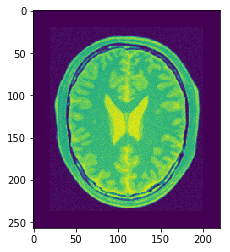

In [2]:
# Load and examine our input images

PixelType = itk.ctype('float')

fixed_image = itk.imread('data/BrainProtonDensitySliceBorder20.png', PixelType)
# itk 5.1b1
# plt.imshow(np.asarray(fixed_image))
plt.imshow(itk.array_from_image(fixed_image))

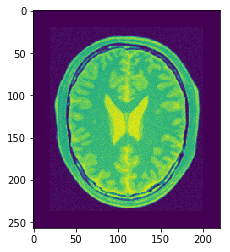

In [3]:
moving_image = itk.imread('data/BrainProtonDensitySliceShifted13x17y.png', PixelType)

plt.imshow(itk.array_from_image(fixed_image))

In [4]:
# Define our registration components

Dimension = fixed_image.GetImageDimension()
FixedImageType = type(fixed_image)
MovingImageType = type(moving_image)

# itk.D is the 'double' C type
TransformType = itk.TranslationTransform[itk.D, Dimension]
initial_transform = TransformType.New()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        learning_rate=4,
        minimum_step_length=0.001,
        relaxation_factor=0.5,
        number_of_iterations=200)

metric = itk.MeanSquaresImageToImageMetricv4[
    FixedImageType, MovingImageType].New()

In [10]:
# Set up our registration method with its components

registration = itk.ImageRegistrationMethodv4.New(fixed_image=fixed_image,
        moving_image=moving_image,
        metric=metric,
        optimizer=optimizer,
        initial_transform=initial_transform)

In [8]:
# %load solutions/6_Registration_Framework_answer1.py

In [11]:
# Set the initial parameters for the optimization problem

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
# X translation
initial_parameters[0] = 0.0
# X translation
initial_parameters[1] = 0.0
moving_initial_transform.SetParameters(initial_parameters)
registration.SetMovingInitialTransform(moving_initial_transform)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)

In [12]:
# Set up multi-resolution registration parameters

# In multi-resolution registration, registration is first performed
# on an image with reduced content. Then the resulting spatial transformation
# is used at the start of optimization at the next level.

# This improves robustness and speed

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

In [13]:
# Run the registration! 

registration.Update()

In [14]:
# Examine the result

transform = registration.GetTransform()
final_parameters = transform.GetParameters()
x_translation = final_parameters[0]
y_translation = final_parameters[1]

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result:")
print(" Translation X = " + str(x_translation))
print(" Translation Y = " + str(y_translation))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result:
 Translation X = 13.00123653240422
 Translation Y = 16.999943471681494
 Iterations    = 22
 Metric value  = 0.0006793961893802234


In [15]:
# Our resulting transform is a composition, or chaining,
# of the initial transform and the optimized transform
output_transform = itk.CompositeTransform[itk.D, Dimension].New()
output_transform.AddTransform(moving_initial_transform)
output_transform.AddTransform(registration.GetModifiableTransform())

In [17]:
itk.resample_image_filter?

In [18]:
resampled_moving_image = itk.resample_image_filter(moving_image,
        transform=output_transform,
        use_reference_image=True,
        default_pixel_value=1,
        reference_image=fixed_image)

In [17]:
# %load solutions/6_Registration_Framework_answer2.py

In [19]:
view(resampled_moving_image, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

In [20]:
difference = itk.subtract_image_filter(fixed_image, resampled_moving_image)

view(difference, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

In [21]:
original_difference = itk.subtract_image_filter(fixed_image, moving_image)

view(original_difference, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

## Volumetric Image Registration that Just Works in Python

[Coming soon to a notebook near you!](https://github.com/InsightSoftwareConsortium/ITKElastix)

Featuring:

- Easily install, cross-platform Python packages
- Proven registration method and settings that **just works** for most use cases:

  * Multi-resolution
  * Fast mutual-information similarity metric
  * Rigid -> affine -> deformable b-spline transformations
  * Fast adaptive stocastic gradient decent optimization, automatic parameter estimation
  * Also generates resampled moving image by default
  * Intelligent sampling
  * Adjustable to new problems
  
Install:

```
pip install itk-elastix	
```

Use:

```
import itk	

# The fixed and moving image can be an itk.Image or a numpy.ndarray	
fixed_image = itk.imread('path/to/fixed_image.mha')	
moving_image = itk.imread('path/to/moving_image.mha')	

registered_image = itk.elastix_registration_method(fixed_image, moving_image)
```

### Enjoy ITK!